In [140]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
import pickle
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC, LinearSVC

patient = 1

# 0. Feature Set Calculation Functions

In [3]:
# Globals
COLUMNS = np.array(['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Sig_coef1','Sig_coef2','Sig_coef3','Sig_coef4',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])

In [4]:
def CalcFeatureSet1(cgmNorm_np, cgmSeries_np):
    maxs = np.argmax(cgmNorm_np, axis=1)
    mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

    slopes = []
    time_diffs = []
    for i in range(len(maxs)):
        slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        time_diffs.append(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        slopes.append(slope)

    slopes = np.nan_to_num(slopes)
    time_diffs = np.nan_to_num(time_diffs)
    reg_window_size = 4
    reg_errors = []
    peak_values = []
    peak_heights = []
    peak_time_diffs = []
    peak_times = []
    for j in range(len(cgmNorm_np)):
        errors = np.array([])
        for i in range(len(cgmNorm_np[j])-reg_window_size):
            times = cgmSeries_np[i:i+reg_window_size-1]
            if np.isnan(times).any():
                errors = np.append(errors, -1)
                continue
            coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
            poly = np.poly1d(coeffs)
            error = poly(cgmSeries_np[i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
            errors = np.append(errors, error)
        peaks, height_dict = find_peaks(errors, height = 0)
        heights = height_dict['peak_heights']
        sorted_args = heights.argsort()
        peaks = peaks[sorted_args]
        peaks = peaks[-2:]
        heights = heights[sorted_args]
        heights = heights[-2:]
        values = cgmNorm_np[j][peaks+reg_window_size-1]
        times1 = cgmSeries_np[peaks+reg_window_size]
        times2 = cgmSeries_np[peaks+reg_window_size-1]
        reg_errors.append(errors)
        while(len(values) < 2):
            values = np.append(values, 0)
            heights = np.append(heights, 0)
            times1 = np.append(times, 0)
            times2 = np.append(times2, 0)
        peak_values.append(values)
        peak_heights.append(heights)
        peak_time_diffs.append(times1)
        peak_times.append(times2)
    reg_errors = np.array(reg_errors)
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, slopes[i])
        matrix_row = np.append(matrix_row, time_diffs[i])
        matrix_row = np.append(matrix_row, peak_values[i])
        matrix_row = np.append(matrix_row, peak_heights[i])
        matrix_row = np.append(matrix_row, peak_times[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [5]:
def CalcFeatureSet2(cgmNorm_np, cgmSeries_np):
    window_mins = []
    window_maxs = []
    window_means = []
    window_vars = []
    for i in range(0, len(cgmNorm_np)):
        window_input = DataFrame(cgmNorm_np[i][::-1])
        width=5
        shifted=window_input.shift(width - 1)
        window=shifted.rolling(window=width)
        dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
        dataframe.columns = ['var', 'min', 'mean', 'max']
        window_features = dataframe.nlargest(2,'var')
        window_values = window_features.values
        window_mins.append([window_values[0][1], window_values[1][1]])
        window_maxs.append([window_values[0][3], window_values[1][3]])
        window_vars.append([window_values[0][0], window_values[1][0]])
        window_means.append([window_values[0][2], window_values[1][2]])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, window_mins[i])
        matrix_row = np.append(matrix_row, window_maxs[i])
        matrix_row = np.append(matrix_row, window_vars[i])
        matrix_row = np.append(matrix_row, window_means[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [6]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def CalcFeatureSet3(cgmNorm_np, cgmSeries_np):
    n_series = []
    n_datenum = []
    sig1 = []
    sig2 = []
    sig3 = []
    sig4 = []
    for i in range(0, len(cgmNorm_np)):
        idx = np.isfinite(cgmSeries_np) & np.isfinite(cgmNorm_np[i])
        n_series.append(cgmNorm_np[i][idx])  
        n_datenum.append(cgmSeries_np[idx])
    for i in range(0,len(cgmNorm_np)):
        if(len(n_series[i]) !=0 ):
            try:
                p0 = [max(n_series[i]), np.median(n_datenum[i]),250,min(n_series[i])] 
                popt, pcov = curve_fit(sigmoid, n_datenum[i], n_series[i],p0,method='trf')
            except: 
                popt=[0,0,0,0]

            sig1.append(popt[0])
            sig2.append(popt[1])
            sig3.append(popt[2])
            sig4.append(popt[3])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, sig1[i])
        matrix_row = np.append(matrix_row, sig2[i])
        matrix_row = np.append(matrix_row, sig3[i])
        matrix_row = np.append(matrix_row, sig4[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [7]:
def CalcFeatureSet4(cgmNorm_np, cgmSeries_np):
    Feature_vector=[]
    for i in range(0, len(cgmNorm_np)):
    #FFT
        fastfouriertransform=rfft(cgmNorm_np[i])
        fft_max=np.nanmax(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_max)
        fft_min=np.nanmin(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_min)
        fft_mean=np.nanmean(fastfouriertransform)
        fft_variance=np.nanvar(fastfouriertransform)
        Feature_vector.append(np.array([fft_max,fft_min,fft_mean,fft_variance]))
    matrix = np.array(Feature_vector)
    return matrix

In [8]:
def MergedFeatures(cgmNorm_np, cgmSeries_np):
    feature_set_1 = CalcFeatureSet1(cgmNorm_np, cgmSeries_np)
    feature_set_2 = CalcFeatureSet2(cgmNorm_np, cgmSeries_np)
    feature_set_3 = CalcFeatureSet3(cgmNorm_np, cgmSeries_np)
    feature_set_4 = CalcFeatureSet4(cgmNorm_np, cgmSeries_np)
    features = np.concatenate((feature_set_1, feature_set_2), axis=1)
    features = np.concatenate((features, feature_set_3), axis=1)
    features = np.concatenate((features, feature_set_4), axis=1)
    features = np.nan_to_num(features)
    return features

In [9]:
def GenerateDF(features, columns):
    feature_df = pd.DataFrame(features, columns=columns)
    return feature_df

In [10]:
def NormalizeDF(feature_df, columns, max_scale):
    for i in columns:
        feature_df[i] = feature_df[i]/max_scale[i]
    return feature_df
#     means = feature_df.mean(axis=0)
#     large_means = np.argwhere(means>1).flatten()
#     small_means = np.argwhere(means<-1).flatten()
#     for i in large_means:
#         base = int(np.log10(means[i]))+1
#         if base > 1:
#             feature_df[columns[i]] = np.nan_to_num(np.log10(feature_df[columns[i]].replace(0, np.nan)))/base
#     for i in small_means:
#         base = int(np.log10(np.abs(means[i])))+1
#         if base > 1:
#             feature_df[columns[i]] = np.sign(feature_df[columns[i]])*np.nan_to_num(np.log10(np.abs(feature_df[columns[i]].replace(0, np.nan))))/base
# #     print(large_means)
#     return feature_df

# 1. Calculating Feature Sets

## 1.1 Reading Meal Data

In [27]:
file_no = [1, 2, 3, 4, 5]

In [28]:
cgmData = pd.read_csv("ComparisonData/mealData" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/mealData" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
max_scale = features_df.abs().max(axis=0)
max_scale.to_pickle('DataScale.pkl')
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('MealFeatures.csv', index=False)

cgmData = pd.read_csv("ComparisonData/Nomeal" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/Nomeal" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('NoMealFeatures.csv', index = False)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.223958,0.400000,0.786632,0.6925,0.379195,0.418994,0.461538,0.269231,0.672222,0.663889,...,0.702505,0.684127,-0.000179,0.157098,0.005127,0.001196,0.704449,-0.305146,0.634014,0.501904
1,0.181818,0.366667,0.370180,0.5000,0.197987,0.242086,0.230769,0.538462,0.419444,0.391667,...,0.451461,0.428571,-0.000178,0.105077,0.499994,0.000705,0.377450,-0.368154,0.351433,0.148848
2,0.193182,0.733333,0.519280,0.4700,0.308725,0.275605,0.769231,0.692308,0.250000,0.230556,...,0.328288,0.292593,0.000544,0.101382,0.003870,0.000346,0.376598,-0.543992,0.284399,0.155170
3,0.245536,0.466667,0.383033,0.5350,0.305369,0.175047,0.653846,1.000000,0.341667,0.327778,...,0.382568,0.360847,0.000301,0.147579,0.124742,0.000625,0.433015,-0.226763,0.418339,0.191966
4,0.100216,0.966667,0.336761,0.4000,0.171141,0.100559,0.423077,0.615385,0.311111,0.297222,...,0.338205,0.322222,0.000349,0.079098,0.002012,0.000404,0.374979,-0.273501,0.318875,0.145182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000000,0.000000,0.431877,0.4100,0.147651,0.096834,0.730769,0.461538,0.483333,0.480556,...,0.484864,0.476190,-0.000050,0.100701,0.167965,0.000747,0.440430,-0.016335,0.473434,0.193096
240,0.114583,0.100000,0.421594,0.7875,0.174497,0.474860,0.923077,0.153846,0.675000,0.636111,...,0.720772,0.687302,-0.000417,0.100093,0.125973,0.001138,0.563832,-0.089779,0.700013,0.323749
241,0.000000,0.000000,0.910026,0.7875,0.248322,0.474860,0.115385,0.538462,0.675000,0.636111,...,0.720772,0.687302,-0.000536,0.100893,0.499999,0.001435,0.715528,-0.181405,0.835001,0.522252
242,0.258102,0.900000,0.796915,0.5950,0.265101,0.163873,0.884615,0.576923,0.394444,0.425000,...,0.452505,0.500000,0.000961,0.102585,0.001567,0.000517,0.604568,-0.738501,0.472639,0.393181


,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.144231,0.866667,0.501285,0.3575,0.154362,0.093110,0.846154,0.500000,0.447222,0.461111,...,0.456159,0.480423,0.000627,0.108393,0.001025,0.000377,0.390830,-0.348937,0.337304,0.165106
1,0.043750,0.666667,0.228792,0.2575,0.204698,0.232775,0.307692,0.884615,0.250000,0.250000,...,0.251566,0.261905,0.000106,0.056948,0.000748,0.000317,0.227373,-0.045013,0.223039,0.053624
2,0.035511,0.733333,0.221080,0.2350,0.144295,0.093110,0.346154,0.807692,0.205556,0.211111,...,0.208246,0.217989,0.000164,0.021526,0.000920,0.000238,0.216550,-0.055635,0.207839,0.048761
3,0.062500,0.033333,0.275064,0.2350,0.137584,0.229050,0.692308,0.500000,0.277778,0.305556,...,0.313152,0.342857,-0.000035,0.247183,0.249993,0.000470,0.277314,-0.029355,0.332700,0.079420
4,0.187500,0.066667,0.380463,0.6275,0.164430,0.290503,0.769231,0.076923,0.558333,0.536111,...,0.587161,0.566667,-0.000273,0.980133,0.249876,0.000750,0.442986,-0.055481,0.543379,0.204876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.149554,0.933333,0.300771,0.5250,0.261745,0.171322,0.153846,0.923077,0.472222,0.455556,...,0.498956,0.481481,0.000000,0.000000,0.000000,0.000000,0.405744,-0.277090,0.358404,0.176746
231,0.222656,0.266667,0.562982,0.5600,0.419463,0.391061,0.461538,0.153846,0.566667,0.552778,...,0.588727,0.571429,0.000141,0.149809,0.014424,0.000924,0.565877,-0.091022,0.569134,0.331637
232,0.142241,0.966667,0.455013,0.5125,0.362416,0.420857,0.230769,0.461538,0.466667,0.466667,...,0.512004,0.495238,0.000000,0.000000,0.000000,0.000000,0.522328,-0.240149,0.479270,0.287802
233,0.200521,0.800000,0.544987,0.5625,0.224832,0.202980,0.423077,0.730769,0.397222,0.372222,...,0.434760,0.411640,0.010025,-0.172258,0.000601,-0.008907,0.525652,-0.323542,0.417438,0.295973


## 1.2 Generating PCA

In [37]:
PCA_filename = 'PCA.pkl'

In [47]:
def GeneratePCA(data, PCA_filename):
    pca = PCA(n_components=5)
    pca.fit(data)
    components = pca.components_
    variances = pca.explained_variance_
    x = [i for i in range(0, len(components[0]))]
    for i in range(0, 5):
        plt.figure()
        plt.bar(x, components[i])
        plt.xticks(np.arange(len(components[0])), x, rotation=90)
        plt.show()
        positives = np.array(np.argwhere(components[i] > 0).flatten())
        positive_sorted = np.argsort(components[i][:])
    PCA_file = open(PCA_filename, 'wb')
    pickle.dump(pca, PCA_file)
    PCA_file.close()

In [50]:
def Transform(data, PCA_filename):
    PCA_file = open(PCA_filename, 'rb')
    pca = pickle.load(PCA_file)
    PCA_file.close()
    return pca.transform(data)

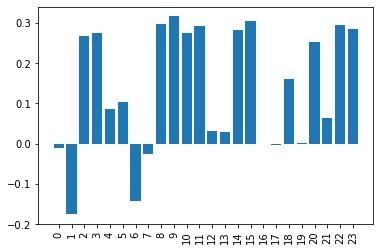

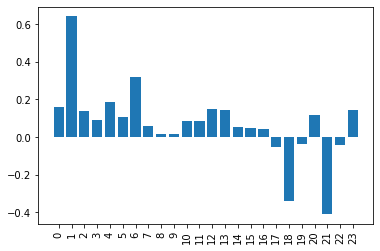

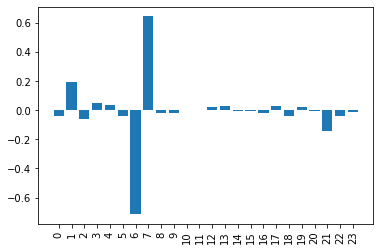

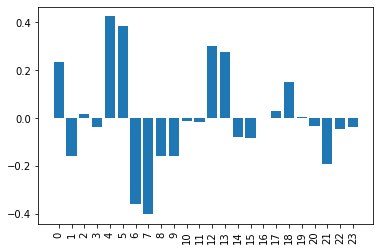

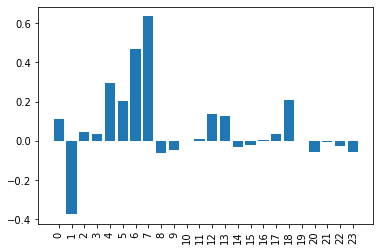

In [51]:
mealData = pd.read_csv('MealFeatures.csv')
noMealData = pd.read_csv('NoMealFeatures.csv')

GeneratePCA(mealData, PCA_filename)
mealTransform = Transform(mealData, PCA_filename)
noMealTransform = Transform(noMealData, PCA_filename)

In [121]:
mealLabels = np.ones((mealTransform.shape[0], 1))
noMealLabels = np.zeros((noMealTransform.shape[0], 1))

mealDataWithLabels = np.concatenate((mealTransform, mealLabels), axis=1)
noMealDataWithLabels = np.concatenate((noMealTransform, noMealLabels), axis=1)

dataset = np.concatenate((mealDataWithLabels, noMealDataWithLabels), axis=0)
np.random.shuffle(dataset)

# Training Model

## SVM

In [162]:
class Classifiers:
    def __init__(self):
        return
    
    def genClassifier1(self):
        self.Classifier1 = SVC(kernel='rbf', gamma='auto')
#         self.Classifier1 = NuSVC(nu=0.9, kernel='rbf', gamma='auto')
        
    def trainClassifier1(self, train_data):
        self.genClassifier1()
        self.Classifier1.fit(train_data[:, :-1], train_data[:, -1])
        
    def validateClassifier1(self, test_data):
        labels = self.Classifier1.predict(test_data[:, :-1])
        return labels
    
    def loadClassifier1(self, filename):
        return
        
    def saveClassifier1(self, filename):
        return

In [163]:
def evaluate(test_labels, labels):
    TP = 0.0
    FP = 0.0
    TN = 0.0
    FN = 0.0
    base = len(labels)
    for i in range(len(labels)):
        if labels[i] == 1:
            if test_labels[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if test_labels[i] == 0:
                TN += 1
            else:
                FN += 1
    acc = (TP+TN)/base
    prec = (TP)/(TP+FP)
    rec = (TP)/(TP+FN)
    return acc, prec, rec

In [164]:
no_k = 5
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
models = Classifiers()
for train, test in kf.split(dataset):
    models.trainClassifier1(dataset[train])
    labels = models.validateClassifier1(dataset[test])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))

Acc = 0.656250, Prec = 0.622642, Rec = 0.717391, F1 = 0.666667
Acc = 0.552083, Prec = 0.578125, Rec = 0.698113, F1 = 0.632479
Acc = 0.614583, Prec = 0.560000, Rec = 0.651163, F1 = 0.602151
Acc = 0.531250, Prec = 0.551020, Rec = 0.540000, F1 = 0.545455
Acc = 0.652632, Prec = 0.731707, Rec = 0.576923, F1 = 0.645161
MEAN: Acc = 0.601360, Prec = 0.608699, Rec = 0.636718, F1 = 0.622393
